In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
from collections import Counter

In [2]:
data =  spec1d.Spec1d('../RXJ1131_spec.fits', informat='mwa')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]


Reading spectrum from ../RXJ1131_spec.fits
Expected file format: mwa
 Spectrum Start:  5020.78
 Spectrum End:     8219.18
 Dispersion (1st pixel):   0.80
 Dispersion (average):      0.80



### Checking whether the redshift calculated from the galaxy spectra is correct by drawing the position of the absoprtion lines with the calculated redshift.


Line        lambda_rest  lambda_obs
----------  -----------  -----------
CN bandhd     3883.00       5028.48
CaII K        3933.67       5094.10
CaII H        3968.47       5139.17
H-delta       4101.00       5310.80
G-band        4305.00       5574.97
H-gamma       4340.00       5620.30
Fe4383        4383.00       5675.98
Ca4455        4455.00       5769.22
Fe4531        4531.00       5867.64
H-beta        4861.00       6294.99
Mg I (b)      5176.00       6702.92
Na I (D)      5889.95       7627.49
Na I (D)      5895.92       7635.22



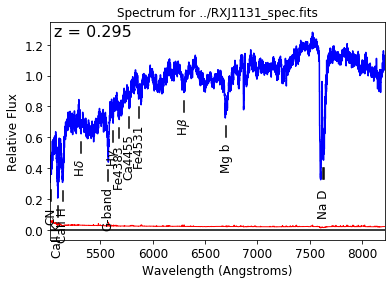

In [3]:
data.plot()
data.mark_lines('abs', z=0.295)